In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [3]:
# negative of the gravitational force
def grad_V():
    return np.array([0, 1])

In [4]:
def fmin(f, args=None):
    res = minimize_scalar(f, args=args)
    assert res.success
    assert abs(res.fun) < 1e-8
    return res.x

# Classic Rattle

In [5]:
def half_step_1(ell, q0, p0, h):
    p_half = p0 - h/2*(grad_V() + q0*ell)
    q1 = q0 + h*p_half
    return q1, p_half

def f_1(ell, q0, p0, h):
    q1, p_half = half_step_1(ell, q0, p0, h)
    return (q1@q1 - 1)**2

def half_step_2(emm, q1, p_half, h):
    p1 = p_half - h/2*(grad_V() + q1*emm)
    return p1

def f_2(emm, q1, p_half, h):
    p1 = half_step_2(emm, q1, p_half, h)
    return (q1@p1)**2

In [6]:
def rattle_one_step(q0, p0, h, fmin=fmin):
    ell = fmin(f_1, args=(q0, p0, h))
    q1, p_half = half_step_1(ell, q0, p0, h)
    emm = fmin(f_2, args=(q1, p_half, h))
    p1 = half_step_2(emm, q1, p_half, h)
    return q1, p1, ell, emm

In [7]:
h = 0.1

q0 = np.array([1, 0])
p0 = np.array([0, 0])

solution = []
for _ in range(1000):
    q0, p0, ell, emm = rattle_one_step(q0, p0, h)
    solution.append((q0, p0, ell, emm))

qs = np.vstack([s[0] for s in solution])
ps = np.vstack([s[1] for s in solution])
ells = np.array([s[2] for s in solution])
emms = np.array([s[3] for s in solution])

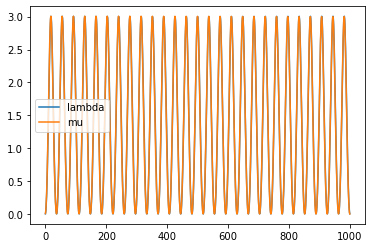

In [8]:
plt.plot(ells, label="lambda")
plt.plot(emms, label="mu")
plt.legend()

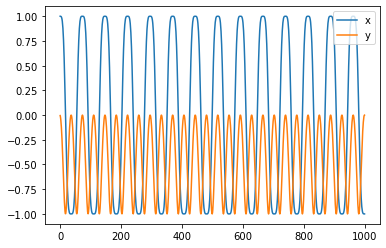

In [9]:
plt.plot(qs[:, 0], label="x")
plt.plot(qs[:, 1], label="y")
plt.legend()

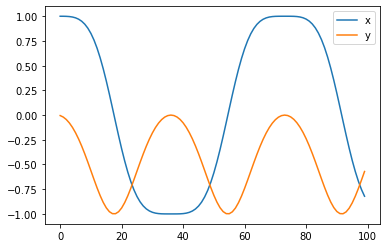

In [10]:
plt.plot(qs[:100, 0], label="x")
plt.plot(qs[:100, 1], label="y")
plt.legend()

In [11]:
def count_peaks(traj):
    peaks = (traj > 0.9).astype(int)
    return np.sum(np.diff(peaks) == 1)

In [12]:
count_peaks(qs[:, 0])

13

# Feedback Rattle (constraint only)

In [13]:
K = 10

def rattle_fi_one_step(q0, p0, h):
    p_half = p0 - h/2*(grad_V() + K*(q0@q0 - 1)*q0)
    q1 = q0 + h*p_half
    p1 = p_half - h/2*(grad_V() + K*(q1@q1 - 1)*q1)
    return q1, p1

In [14]:
h = 0.1

q0 = np.array([1, 0])
p0 = np.array([0, 0])

solution = []
for _ in range(1000):
    q0, p0 = rattle_fi_one_step(q0, p0, h)
    solution.append((q0, p0))

qs = np.vstack([s[0] for s in solution])
ps = np.vstack([s[1] for s in solution])

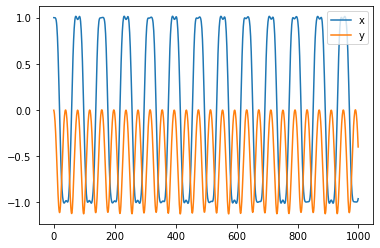

In [15]:
plt.plot(qs[:, 0], label="x")
plt.plot(qs[:, 1], label="y")
plt.legend()

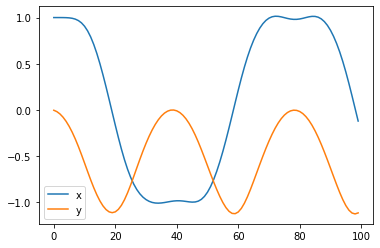

In [16]:
plt.plot(qs[:100, 0], label="x")
plt.plot(qs[:100, 1], label="y")
plt.legend()

In [17]:
count_peaks(qs[:, 0])

12

# Feedback Euler (constraint and energy)

In [18]:
def H(q, p):
    return 0.5*p@p + grad_V()@q

In [19]:
K1 = 5
K2 = 5
K3 = 5

def euler_fi_one_step(q0, p0, h, H0):
    f = grad_V()
    
    dq = p0 - (p0@q0)/(q0@q0) * q0
    dp = -f + (p0@q0)/(q0@q0) * p0 + (f@q0 - p0@p0)/(q0@q0) * q0
    
    Ediff = H(q0, p0) - H0
    q1 = q0 + h*(dq         - K1*(q0@q0 - 1)*q0    - K2*Ediff*f         - K3*(q0@p0)*p0)
    p1 = p0 + h*(dp                                - K2*Ediff*p0        - K3*(q0@p0)*q0)
    return q1, p1

In [20]:
h = 0.1

q0 = np.array([1, 0])
p0 = np.array([0, 0])
H0 = H(q0, p0)

solution = []
for _ in range(1000):
    q0, p0 = euler_fi_one_step(q0, p0, h, H0)    
    solution.append((q0, p0))

qs = np.vstack([s[0] for s in solution])
ps = np.vstack([s[1] for s in solution])

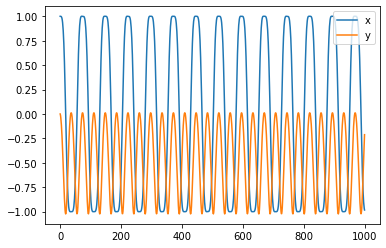

In [21]:
plt.plot(qs[:1000, 0], label="x")
plt.plot(qs[:1000, 1], label="y")
plt.legend()

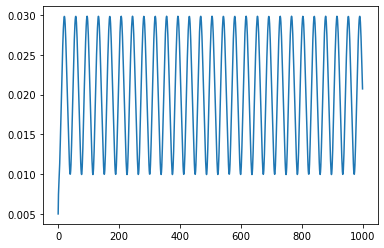

In [22]:
hs = [H(q, p) for (q, p) in zip(qs, ps)]

plt.plot(hs[:1000])

In [23]:
count_peaks(qs[:, 0])

13

# Variable step-size feedback integrator

In [24]:
K1 = 5
K2 = 5
K3 = 5

def rhs(t, x, H0):
    q0 = x[:2]
    p0 = x[2:]

    f = grad_V()
    
    dq = p0 - (p0@q0)/(q0@q0) * q0
    dp = -f + (p0@q0)/(q0@q0) * p0 + (f@q0 - p0@p0)/(q0@q0) * q0
    
    Ediff = H(q0, p0) - H0
    dq +=        - K1*(q0@q0 - 1)*q0    - K2*Ediff*f         - K3*(q0@p0)*p0
    dp +=                               - K2*Ediff*p0        - K3*(q0@p0)*q0
    return np.hstack((dq, dp))

sol = solve_ivp(rhs, [0, 7.4], [1, 0, 0, 0], method="RK45", args=(H0,))

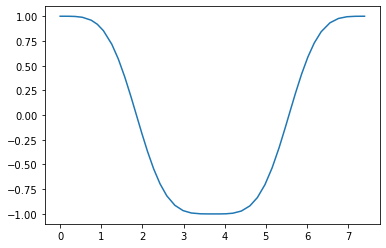

In [25]:
plt.plot(sol.t, sol.y[0])

# Comparison Rattle/FI

In [26]:
h = 0.1

N = 3000

In [27]:
q0 = np.array([1, 0])
p0 = np.array([0, 0])
H0 = H(q0, p0)

solution_fi = []
for _ in range(N):
    q0, p0 = euler_fi_one_step(q0, p0, h, H0)    
    solution_fi.append((q0, p0))
    
qs_fi = np.vstack([s[0] for s in solution_fi])
ps_fi = np.vstack([s[1] for s in solution_fi])

In [28]:
q0 = np.array([1, 0])
p0 = np.array([0, 0])

solution_ra = []
for _ in range(N):
    q0, p0, *_ = rattle_one_step(q0, p0, h)    
    solution_ra.append((q0, p0))
    
qs_ra = np.vstack([s[0] for s in solution_ra])
ps_ra = np.vstack([s[1] for s in solution_ra])

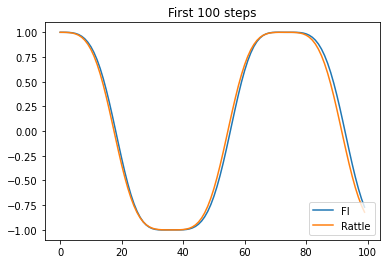

In [29]:
ts = np.arange(0, 100)
plt.plot(ts, qs_fi[:100, 0], label="FI")
plt.plot(ts, qs_ra[:100, 0], label="Rattle")
plt.legend(loc="lower right")
plt.title("First 100 steps")

pass

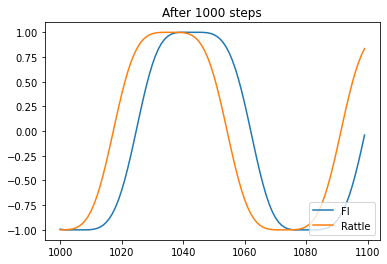

In [30]:
ts = np.arange(1000, 1100)
plt.plot(ts, qs_fi[1000:1100, 0], label="FI")
plt.plot(ts, qs_ra[1000:1100, 0], label="Rattle")
plt.legend(loc="lower right")
plt.title("After 1000 steps")

pass

# Calculation of fundamental period

In [31]:
# Exact period
from scipy.special import ellipk

T = 4*ellipk(0.5)
T

7.4162987092054875

In [32]:
def period(xs, h):
    breaks = np.diff((xs > 0.90).astype(int))
    stops = np.where(breaks == -1)[0]
    starts = np.where(breaks == 1)[0]
    
    if stops[0] < starts[0]:
        stops = stops[1:]
 
    if starts[-1] > stops[-1]:
        starts = starts[:-1]

    peaks = (starts + stops)/2
    return h*np.diff(peaks)
    
p_fi = period(qs_fi[:, 0], h)
p_ra = period(qs_ra[:, 0], h)

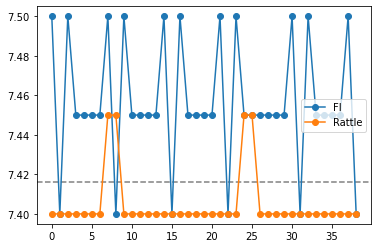

In [33]:
plt.axhline(y=T, color="gray", linestyle="dashed")
plt.plot(p_fi, 'o-', label="FI")
plt.plot(p_ra, 'o-', label="Rattle")
plt.legend(loc="center right")

# Execution time

## Exact solution

In [34]:
def integrate_exact(t_end):
    
    def rhs(t, x):
        theta, pi = x
        return [pi, -np.cos(theta)]

    sol = solve_ivp(rhs, [0, t_end], [0, 0], rtol=1e-8, atol=1e-8)
    theta = sol.y[0]
    return sol.t, np.column_stack((np.cos(theta), np.sin(theta)))

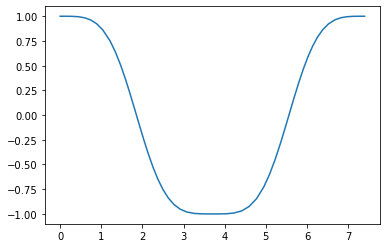

In [36]:
ts, qs_exact = integrate_exact(7.4)
plt.plot(ts, qs_exact[:, 0])

## Force evaluations as a function of step size

In [37]:
def run_rattle(h, tmax=7.4):
    """ Run Rattle up to fixed time limit, with given step size.
    """
    force_counts = 0
    
    nsteps = int(np.ceil(tmax/h))
    
    q0 = np.array([1, 0])
    p0 = np.array([0, 0])
    
    def force():
        nonlocal force_counts
        force_counts += 1
        return np.array([0, 1])

    def half_step_1(ell, q0, p0, h):
        p_half = p0 - h/2*(force() + q0*ell)
        q1 = q0 + h*p_half
        return q1, p_half

    def f_1(ell, q0, p0, h):
        q1, p_half = half_step_1(ell, q0, p0, h)
        return (q1@q1 - 1)**2

    def half_step_2(emm, q1, p_half, h):
        p1 = p_half - h/2*(force() + q1*emm)
        return p1

    def f_2(emm, q1, p_half, h):
        p1 = half_step_2(emm, q1, p_half, h)
        return (q1@p1)**2

    def rattle_one_step(q0, p0, h, fmin=fmin):
        ell = fmin(f_1, args=(q0, p0, h))
        q1, p_half = half_step_1(ell, q0, p0, h)
        emm = fmin(f_2, args=(q1, p_half, h))
        p1 = half_step_2(emm, q1, p_half, h)
        return q1, p1, ell, emm    

    for _ in range(nsteps):
        q0, p0, ell, emm = rattle_one_step(q0, p0, h)
    
    return force_counts, nsteps, q0

In [38]:
def run_feedback_euler(h, tmax=7.4):

    K1 = 5
    K2 = 5
    K3 = 5
    
    force_counts = 0
    
    nsteps = int(np.ceil(tmax/h))
    
    q0 = np.array([1, 0])
    p0 = np.array([0, 0])
    H0 = H(q0, p0)
    
    def force():
        nonlocal force_counts
        force_counts += 1
        return np.array([0, 1])


    def euler_fi_one_step(q0, p0, h, H0):
        f = force()
    
        dq = p0 - (p0@q0)/(q0@q0) * q0
        dp = -f + (p0@q0)/(q0@q0) * p0 + (f@q0 - p0@p0)/(q0@q0) * q0

        Ediff = H(q0, p0) - H0
        q1 = q0 + h*(dq         - K1*(q0@q0 - 1)*q0    - K2*Ediff*f         - K3*(q0@p0)*p0)
        p1 = p0 + h*(dp                                - K2*Ediff*p0        - K3*(q0@p0)*q0)
        return q1, p1
    
    for _ in range(nsteps):
        q0, p0 = euler_fi_one_step(q0, p0, h, H0)
    
    return force_counts, nsteps, q0

In [39]:
def run_variable(atol, rtol, tmax=7.4, method="RK45"):
    
    K1 = 5
    K2 = 5
    K3 = 5
    
    force_counts = 0

    def rhs(t, x, H0):
        nonlocal force_counts
        force_counts += 1
        
        q0 = x[:2]
        p0 = x[2:]

        f = grad_V()

        dq = p0 - (p0@q0)/(q0@q0) * q0
        dp = -f + (p0@q0)/(q0@q0) * p0 + (f@q0 - p0@p0)/(q0@q0) * q0

        Ediff = H(q0, p0) - H0
        dq +=        - K1*(q0@q0 - 1)*q0    - K2*Ediff*f         - K3*(q0@p0)*p0
        dp +=                               - K2*Ediff*p0        - K3*(q0@p0)*q0
        return np.hstack((dq, dp))

    sol = solve_ivp(rhs, [0, tmax], [1, 0, 0, 0], method=method, args=(H0,), atol=atol, rtol=rtol)
    
    return force_counts, None, sol.y[:2, -1]

In [40]:
step_sizes = (0.1, 0.01, 0.001)

In [41]:
rattle_evals = np.array([run_rattle(h)[0] for h in step_sizes])
rattle_evals

array([  1726,  16542, 161039])

In [42]:
feedback_euler_evals = np.array([run_feedback_euler(h)[0] for h in step_sizes])
feedback_euler_evals

array([  74,  740, 7400])

Note: we count a force evaluation for the feedback Euler method as 4 times as expensive as one for the Rattle method, since the vector field involves computing 4 separate gradients.

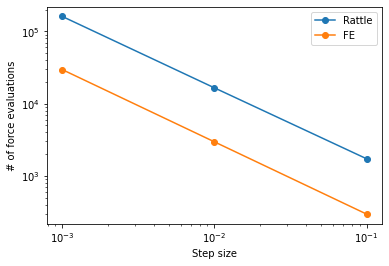

In [43]:
plt.loglog(step_sizes, rattle_evals, "o-", label="Rattle")
plt.loglog(step_sizes, 4*feedback_euler_evals, "o-", label="FE")
plt.xlabel("Step size")
plt.ylabel("# of force evaluations")
plt.legend()

## Step size needed to achieve computational budget

In [44]:
def bracket(fun, nsteps, hleft=0.001, hright=0.1, silent=False):
    nleft = fun(hleft)[0]
    nright = fun(hright)[0]
    
    if nsteps < nright or nsteps > nleft:
        raise RuntimeError(f"Desired: {nsteps}, initial bracket {nright}, {nleft}")

    for _ in range(15):
        # compute middle point
        hmiddle = (hleft*hright)**0.5
        nmiddle = fun(hmiddle)[0]
    
        if not silent:
            print(f"Bracket: {nright}, {nmiddle}, {nleft}", hleft, hmiddle, hright)
    
        if nmiddle in (nleft, nright):
            break
    
        # compare with desired
        if nsteps >= nmiddle:
            nright = nmiddle
            hright = hmiddle
        else:
            nleft = nmiddle
            hleft = hmiddle
            
        if nleft - nright < 10:
            break
    
    # Last evaluation
    h = (hleft*hright)**0.5
    n, nsteps = fun(h)[:-1]
    return h, n, nsteps
    

In [45]:
bracket(run_feedback_euler, 3000)

Bracket: 74, 740, 7400 0.001 0.01 0.1
Bracket: 740, 2341, 7400 0.001 0.0031622776601683794 0.01
Bracket: 2341, 4162, 7400 0.001 0.001778279410038923 0.0031622776601683794
Bracket: 2341, 3121, 4162 0.001778279410038923 0.0023713737056616554 0.0031622776601683794
Bracket: 2341, 2703, 3121 0.0023713737056616554 0.0027384196342643613 0.0031622776601683794
Bracket: 2703, 2904, 3121 0.0023713737056616554 0.0025482967479793467 0.0027384196342643613
Bracket: 2904, 3011, 3121 0.0023713737056616554 0.0024582440689201973 0.0025482967479793467
Bracket: 2904, 2957, 3011 0.0024582440689201973 0.0025028654311746077 0.0025482967479793467
Bracket: 2957, 2984, 3011 0.0024582440689201973 0.0024804544143141134 0.0025028654311746077
Bracket: 2984, 2997, 3011 0.0024582440689201973 0.0024693242703651926 0.0024804544143141134
Bracket: 2997, 3004, 3011 0.0024582440689201973 0.0024637779408595104 0.0024693242703651926


(0.002466549546665294, 3001, 3001)

In [46]:
budgets = [1000, 10_000, 100_000]

In [47]:
computed_budgets_feedback = []

for b in budgets:
    res = bracket(run_feedback_euler, b//4, hleft=0.0001)
    computed_budgets_feedback.append(res)

Bracket: 74, 2341, 74000 0.0001 0.0031622776601683794 0.1
Bracket: 74, 417, 2341 0.0031622776601683794 0.01778279410038923 0.1
Bracket: 74, 176, 417 0.01778279410038923 0.042169650342858224 0.1
Bracket: 176, 271, 417 0.01778279410038923 0.027384196342643614 0.042169650342858224
Bracket: 176, 218, 271 0.027384196342643614 0.03398208328942559 0.042169650342858224
Bracket: 218, 243, 271 0.027384196342643614 0.030505278902670255 0.03398208328942559
Bracket: 243, 257, 271 0.027384196342643614 0.028902639100224503 0.030505278902670255
Bracket: 243, 250, 257 0.028902639100224503 0.029693148482024787 0.030505278902670255
Bracket: 74, 2341, 74000 0.0001 0.0031622776601683794 0.1
Bracket: 2341, 13160, 74000 0.0001 0.0005623413251903491 0.0031622776601683794
Bracket: 2341, 5550, 13160 0.0005623413251903491 0.001333521432163324 0.0031622776601683794
Bracket: 2341, 3604, 5550 0.001333521432163324 0.002053525026457146 0.0031622776601683794
Bracket: 2341, 2904, 3604 0.002053525026457146 0.00254829674

In [48]:
computed_budgets_feedback

[(0.029295227500829236, 253, 253),
 (0.0029609804972080037, 2500, 2500),
 (0.00029598363548360724, 25002, 25002)]

In [49]:
computed_budgets_rattle = []

for b in budgets:
    res = bracket(run_rattle, b, hright=0.5)
    computed_budgets_rattle.append(res)

Bracket: 380, 7408, 161039 0.001 0.022360679774997897 0.5
Bracket: 380, 1637, 7408 0.022360679774997897 0.10573712634405641 0.5
Bracket: 380, 796, 1637 0.10573712634405641 0.22993164891338513 0.5
Bracket: 796, 1126, 1637 0.10573712634405641 0.15592405783474153 0.22993164891338513
Bracket: 796, 952, 1126 0.15592405783474153 0.1893459155176265 0.22993164891338513
Bracket: 952, 1039, 1126 0.15592405783474153 0.17182428082765974 0.1893459155176265
Bracket: 952, 997, 1039 0.17182428082765974 0.1803724639779337 0.1893459155176265
Bracket: 997, 1016, 1039 0.17182428082765974 0.17604649642671513 0.1803724639779337
Bracket: 997, 995, 1016 0.17604649642671513 0.1781963533161358 0.1803724639779337
Bracket: 995, 996, 1016 0.17604649642671513 0.17711816303621367 0.1781963533161358
Bracket: 996, 994, 1016 0.17604649642671513 0.17658151674527303 0.17711816303621367
Bracket: 994, 994, 1016 0.17604649642671513 0.17631380364770266 0.17658151674527303
Bracket: 380, 7408, 161039 0.001 0.022360679774997897

In [50]:
computed_budgets_rattle

[(0.17631380364770266, 994, 42),
 (0.016596083308032857, 9981, 446),
 (0.0016279441778080056, 100089, 4546)]

In [51]:
[h*n for h, _, n in computed_budgets_feedback]

[7.411692557709797, 7.40245124302001, 7.400182854361148]

In [52]:
[h*n for h, _, n in computed_budgets_rattle]

[7.4051797532035115, 7.401853155382654, 7.400634232315194]

In [53]:
# Compare with wall-clock timing (inaccurate)

In [54]:
%timeit -n1 run_rattle(0.016596083308032857)

109 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit -n1 run_feedback_euler(0.0029609804972080037)

79.4 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Error as a function of computational budget

In [56]:
errors_fe = []
for h, _, n in computed_budgets_feedback:
    tmax = h*n
    _, _, qs_computed = run_feedback_euler(h, tmax)
    _, qs_exact = integrate_exact(tmax)
    
    errors_fe.append(abs(qs_computed[0] - qs_exact[-1, 0]))

In [57]:
errors_fe

[3.4883808724295307e-05, 5.87012499431161e-06, 6.174460177588159e-07]

In [58]:
errors_rattle = []
for h, _, n in computed_budgets_rattle:
    tmax = h*n
    _, _, qs_computed = run_rattle(h, tmax)
    _, qs_exact = integrate_exact(tmax)
    
    errors_rattle.append(abs(qs_computed[0] - qs_exact[-1, 0]))

In [59]:
errors_rattle

[2.824454381489261e-08, 4.3284686945810336e-10, 1.2809420191217669e-11]

In [60]:
def parametrize_variable(tol, method="RK45"):
    budget, _, res = run_variable(tol, tol, method=method)
    _, qs_exact = integrate_exact(7.4)
    error = abs(res[0] - qs_exact[-1, 0])
    return budget, error

In [61]:
errors_variable_rk45 = []
for tol in np.logspace(-5, -13, 10):
    errors_variable_rk45.append(parametrize_variable(tol))

In [62]:
errors_variable_rk45

[(464, 2.2551543992221923e-06),
 (620, 1.8540355450902268e-07),
 (884, 2.1128180538454444e-08),
 (1268, 2.6342132919410233e-09),
 (1844, 3.0337965473137274e-10),
 (2738, 3.1733282668255924e-11),
 (4094, 2.967293077915656e-12),
 (6134, 7.37898631086864e-12),
 (9206, 7.94164733974867e-12),
 (13832, 8.013700814046842e-12)]

In [63]:
errors_variable_dop = []
for tol in np.logspace(-5, -13, 10):
    errors_variable_dop.append(parametrize_variable(tol, method="DOP853"))

In [64]:
errors_variable_dop

[(398, 4.4373284657783785e-07),
 (506, 7.80932762900477e-08),
 (758, 9.731348615815705e-09),
 (986, 1.1122607279645536e-09),
 (1214, 6.27546903331222e-11),
 (1514, 7.002176616310862e-13),
 (1874, 7.313705197020681e-12),
 (2366, 7.918110611626616e-12),
 (3038, 8.013478769441917e-12),
 (3890, 8.023248732058619e-12)]

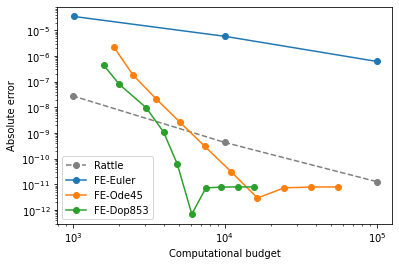

In [65]:
ns = [it[1] for it in computed_budgets_rattle]
plt.loglog(ns, errors_rattle, "o--", label="Rattle", color="gray")
ns = 4*np.array([it[1] for it in computed_budgets_feedback])
plt.loglog(ns, errors_fe, "o-", label="FE-Euler")
ns = 4*np.array([it[0] for it in errors_variable_rk45])
plt.loglog(ns, [err[1] for err in errors_variable_rk45], "o-", label="FE-Ode45")
ns = 4*np.array([it[0] for it in errors_variable_dop])
plt.loglog(ns, [err[1] for err in errors_variable_dop], "o-", label="FE-Dop853")
plt.legend()
plt.xlabel("Computational budget")
plt.ylabel("Absolute error")

pass

In [66]:
parametrize_variable(1e-8)

(1466, 1.1817109513145851e-09)